# CEIA – Análisis de Series de Tiempo I | TP3: Trabajo Final

Notebook del TP3 de la materia **Análisis de Series de Tiempo I** de la Carrera de Especialización en Inteligencia Artificial (CEIA – UBA).

---

**Alumno**

- **Emiliano Iparraguirre** (<emiliano.iparraguirre22@gmail.com>)  
---
**Objetivo**

- 

---
**Datos y utilidades**
- 

In [1]:
# ==== 0. Setup ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

# opcional (auto-ARIMA)
# pip install pmdarima
from pmdarima import auto_arima

In [12]:
# ==== 1. Datos ====
# Leer el Excel
df = pd.read_excel("data/Pedidos - cod1.xlsx")

# Verificar estructura
print(df.head())

    año  semana    COD1
0  2016       1  9126.5
1  2016       2  7458.4
2  2016       3  8848.0
3  2016       4  7353.6
4  2016       5  8304.0


In [ ]:
# Combinar 'año' y 'semana' en una fecha: tomamos el lunes de cada semana ISO
df['fecha'] = pd.to_datetime(df['año'].astype(str) + df['semana'].astype(str) + '1', format='%G%V%u')

# Renombrar la columna de pedidos (si querés más legible)
df = df.rename(columns={'COD1': 'demanda'})

# Ordenar y fijar índice temporal
df = df.sort_values('fecha').set_index('fecha')

# Asegurar frecuencia semanal explícita
y = df['demanda'].asfreq('W-MON')  # W-MON = semanas que terminan en lunes (alineado con ISO)

# Mostrar primeros valores
print(y.head(10))
print(y.describe())

fecha
2016-01-04    9126.5
2016-01-11    7458.4
2016-01-18    8848.0
2016-01-25    7353.6
2016-02-01    8304.0
2016-02-08    7379.5
2016-02-15    9313.8
2016-02-22    8722.5
2016-02-29    8143.4
2016-03-07    8730.9
Freq: W-MON, Name: demanda, dtype: float64
count      235.000000
mean      7817.434085
std       2114.047386
min       3266.800000
25%       6452.000000
50%       7607.000000
75%       8856.400000
max      15400.400000
Name: demanda, dtype: float64


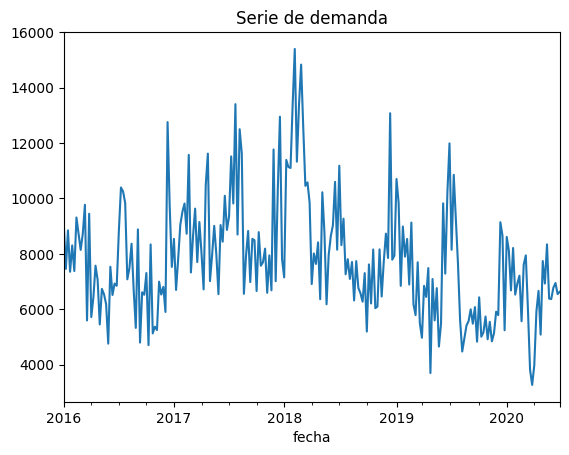

In [ ]:
# ==== 2. EDA básico ====
y.plot(title="Serie de demanda"); plt.show()

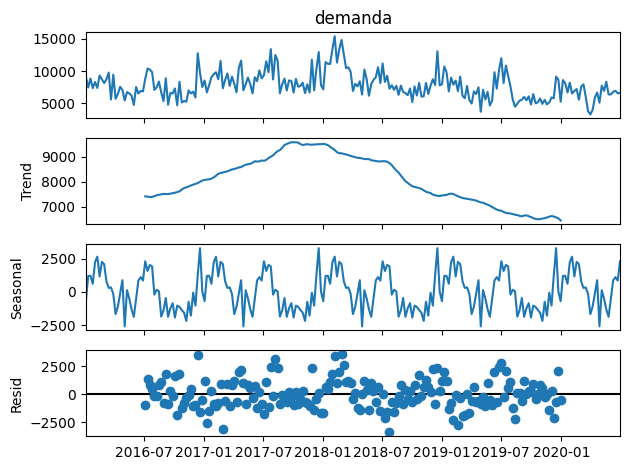

In [14]:
# Descomposición aditiva semanal (periodo 52)
decomp = seasonal_decompose(y.dropna(), model='additive', period=52)
decomp.plot(); plt.show()

In [15]:
# ==== 3. Tests de estacionariedad ====
def adf_test(series):
    s = series.dropna()
    stat, pvalue, *_ = adfuller(s, autolag='AIC')
    return {'ADF_stat': stat, 'pvalue': pvalue}

def kpss_test(series, regression='c'):
    s = series.dropna()
    stat, pvalue, *_ = kpss(s, regression=regression, nlags="auto")
    return {'KPSS_stat': stat, 'pvalue': pvalue, 'reg': regression}

print("Nivel →", adf_test(y))
print("Nivel (KPSS nivel) →", kpss_test(y, 'c'))
print("Nivel (KPSS tendencia) →", kpss_test(y, 'ct'))

Nivel → {'ADF_stat': -4.137199602230756, 'pvalue': 0.0008401262777792877}
Nivel (KPSS nivel) → {'KPSS_stat': 0.5567751910866929, 'pvalue': 0.028879461466961045, 'reg': 'c'}
Nivel (KPSS tendencia) → {'KPSS_stat': 0.2637472801767146, 'pvalue': 0.01, 'reg': 'ct'}


C:\Users\elipa\AppData\Local\Temp\ipykernel_22832\2161363962.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, pvalue, *_ = kpss(s, regression=regression, nlags="auto")


Esos resultados muestran un desacuerdo ADF vs. KPSS:
- ADF (H₀: raíz unitaria → no estacionaria): p = 0.00084 ⇒ rechaza H₀ ⇒ sugiere estacionaria.
- KPSS nivel (H₀: estacionaria en nivel): p ≈ 0.0289 ⇒ rechaza H₀ ⇒ sugiere no estacionaria.
- KPSS tendencia (H₀: estacionaria alrededor de tendencia): p ≤ 0.01 (warning = “p real < 0.01”) ⇒ rechaza H₀ ⇒ no estacionaria.

Interpretación práctica (lo mismo que hacías en R): cuando ADF dice “OK” pero KPSS dice “NO”, suele haber tendencia/estacionalidad o quiebres que el ADF no penaliza igual. En semanal, casi seguro necesitás diferenciación estacional (D=1, s=52) y probablemente d=1 también (como en tu flujo R).

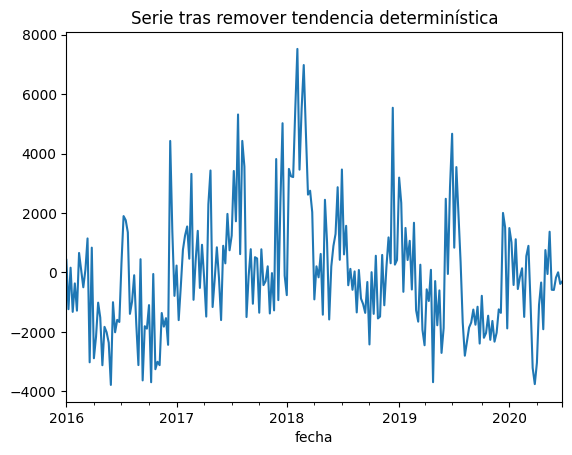

ADF (sin tendencia): {'ADF_stat': -4.402014401767073, 'pvalue': 0.0002944054806726574}
KPSS nivel (sin tendencia): {'KPSS_stat': 0.26374728017672183, 'pvalue': 0.1, 'reg': 'c'}


C:\Users\elipa\AppData\Local\Temp\ipykernel_22832\2161363962.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pvalue, *_ = kpss(s, regression=regression, nlags="auto")


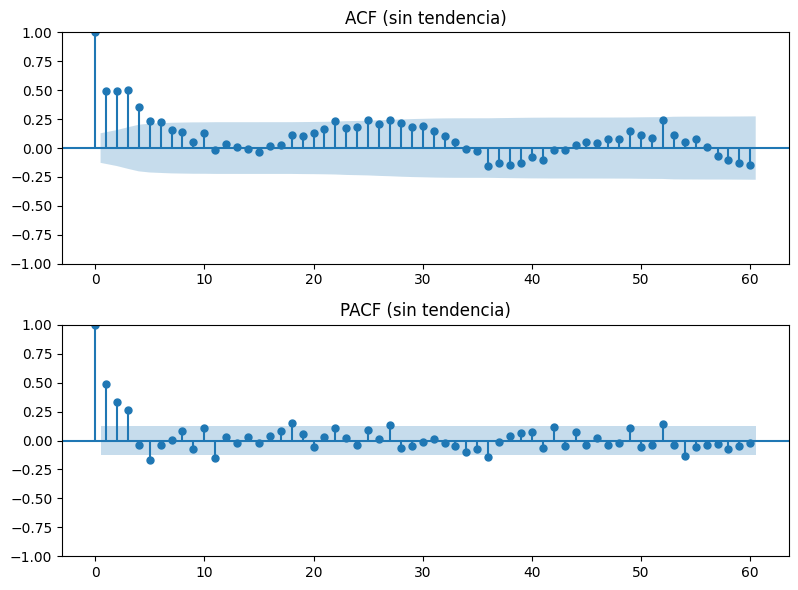

In [ ]:
# Remoción de tendencia determinística (regresión lineal)
# Verificar si la serie tiene tendencia determinística (por el ADF)
# (si hubiera estacionalidad, mejor removerla primero)
t = np.arange(1, len(y.dropna())+1)
coef = np.polyfit(t, y.dropna().values, deg=1)
trend = np.polyval(coef, t)

det_y = pd.Series(y.dropna().values - trend,
                  index=y.dropna().index, name='y_sin_tendencia')

det_y.plot(title="Serie tras remover tendencia determinística"); plt.show()

print("ADF (sin tendencia):", adf_test(det_y))
print("KPSS nivel (sin tendencia):", kpss_test(det_y, 'c'))

# ACF/PACF de la serie sin tendencia
fig, ax = plt.subplots(2,1, figsize=(8,6))
plot_acf(det_y, lags=60, ax=ax[0]); ax[0].set_title("ACF (sin tendencia)")
plot_pacf(det_y, lags=60, ax=ax[1], method='ywm'); ax[1].set_title("PACF (sin tendencia)")
plt.tight_layout(); plt.show()

### Conclusiones – Remoción de tendencia determinística

- **Análisis visual:**  
  Al comparar la serie original con la serie sin tendencia determinística, se observa que ambas mantienen un comportamiento muy similar. No se aprecia un cambio sistemático o lineal en el tiempo, lo que sugiere que **no existe una tendencia determinística significativa** en los pedidos semanales del producto COD1.

- **Resultados de las pruebas estadísticas:**  
  - El **ADF test** mantiene un p-valor menor a 0.05, lo que permite **rechazar la hipótesis nula de raíz unitaria** y sugiere que la serie podría ser estacionaria.  
  - El **KPSS test**, en cambio, arroja un p-valor menor a 0.05, lo que implica **rechazar la hipótesis nula de estacionariedad**.  
  - Esta contradicción entre ADF y KPSS suele indicar que la serie **no es completamente estacionaria**, posiblemente debido a **componentes estacionales o variaciones cíclicas**, más que a una tendencia determinística.

- **Conclusión:**  
  La serie no presenta una **tendencia lineal significativa**, por lo que **no es necesario eliminar una tendencia determinística** antes del modelado.  
  Las fluctuaciones observadas parecen deberse principalmente a **efectos estacionales y ruido aleatorio**.  
  En consecuencia, el siguiente paso debería centrarse en **tratar la estacionalidad y la posible raíz unitaria**, aplicando diferencias adecuadas —por ejemplo, una **diferencia estacional (D=1, s=52)** y posiblemente una **diferencia regular (d=1)** para garantizar la estacionariedad.


## 5) Primera diferencia no estacional y tests

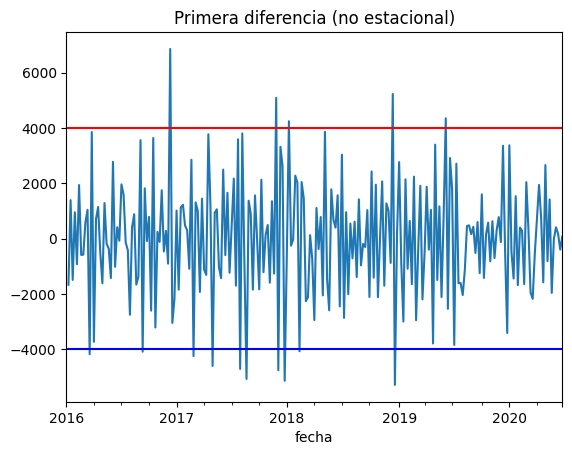

ADF(diff1): {'ADF_stat': -18.86011809214938, 'pvalue': 0.0}
KPSS nivel (diff1): {'KPSS_stat': 0.013065108648218679, 'pvalue': 0.1, 'reg': 'c'}


C:\Users\elipa\AppData\Local\Temp\ipykernel_22832\2161363962.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pvalue, *_ = kpss(s, regression=regression, nlags="auto")


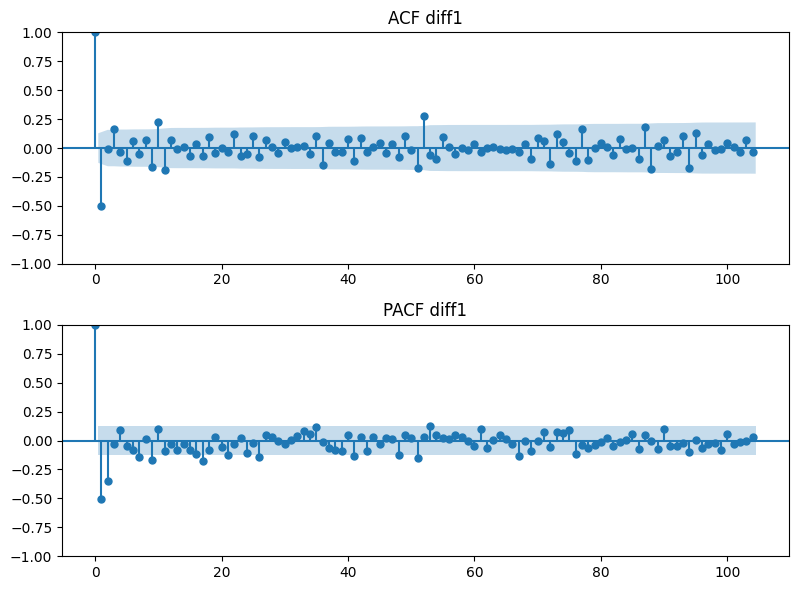

In [19]:
y_diff = y.diff(1)

# Visual + bandas guía (equivalente a líneas ±4000 si querés)
ax = y_diff.plot(title="Primera diferencia (no estacional)")
ax.axhline(4000, color='r'); ax.axhline(-4000, color='b'); plt.show()

print("ADF(diff1):", adf_test(y_diff))
print("KPSS nivel (diff1):", kpss_test(y_diff, 'c'))

# ACF/PACF con lag alto (104) para ver estacionalidad anual
fig, ax = plt.subplots(2,1, figsize=(8,6))
plot_acf(y_diff.dropna(), lags=104, ax=ax[0]); ax[0].set_title("ACF diff1")
plot_pacf(y_diff.dropna(), lags=104, ax=ax[1], method='ywm'); ax[1].set_title("PACF diff1")
plt.tight_layout(); plt.show()


### Conclusiones – Primera diferencia no estacional y pruebas de estacionariedad

- **Análisis visual:**  
  La serie en primera diferencia muestra un comportamiento claramente más estable alrededor de la media, sin tendencia ni variaciones sistemáticas.  
  Los límites de referencia (±4000) indican que las fluctuaciones son más simétricas y de menor amplitud, evidenciando una reducción de la varianza respecto a la serie original.  
  No se observan patrones visibles de tendencia ni varianza creciente, lo que sugiere que la serie se ha estabilizado tras la diferenciación.

- **Resultados estadísticos:**  
  - **ADF test:** p-valor = 0.0000 → **rechaza la hipótesis nula de raíz unitaria**, lo que confirma que la serie diferenciada es estacionaria.  
  - **KPSS test:** p-valor = 0.1 → **no se rechaza la hipótesis nula de estacionariedad**, reforzando la conclusión anterior.  
  - El *warning* de interpolación en KPSS indica que el estadístico está fuera del rango tabulado y que el p-valor real es **mayor** que el informado (aún más evidencia de estacionariedad).

- **ACF y PACF:**  
  En las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) se observa una rápida caída en los primeros rezagos, sin patrones de persistencia o tendencia, lo cual **confirma el carácter estacionario** de la serie.  
  Se aprecian picos aislados, pero sin estructura estacional marcada, lo que sugiere que la parte no estacional ya ha sido adecuadamente diferenciada.

- **Conclusión general:**  
  La **primera diferencia (d = 1)** logra eliminar la no estacionariedad presente en la serie original, generando una serie con media y varianza estables.  
  A partir de estos resultados, la modelización puede continuar considerando que la serie es **estacionaria en su primera diferencia**, y que la siguiente etapa debe enfocarse en analizar la **posible estacionalidad anual (D = 1, s = 52)**.

## 6) Candidatos SARIMA y auto_arima

In [20]:
# Candidatos (p,d,q)(P,D,Q)[s]; con d=1 y D=1 según tu flujo
candidatos = [
    ((1,1,1), (1,1,1,52)),  # Candidato 1 del R
    ((2,1,1), (1,1,1,52)),
    ((1,1,3), (1,1,1,52)),
    ((2,1,3), (1,1,1,52)),
]

# Opcional: alternativa auto_arima para comparar (requiere pmdarima)
auto_model = auto_arima(y.dropna(), seasonal=True, m=52, stepwise=True, trace=True,
                        d=1, D=1, suppress_warnings=True)
print(auto_model.summary())
order_aa = auto_model.order
seas_aa  = auto_model.seasonal_order
print("auto_arima →", order_aa, seas_aa)


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=95.49 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[52]             : AIC=3359.875, Time=0.50 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[52]             : AIC=3280.942, Time=7.61 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=26.33 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,0)[52]             : AIC=3298.779, Time=0.63 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=54.03 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=63.34 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=27.31 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=115.61 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[52]             : AIC=3343.958, Time=5.29 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[52]             : AIC=3256.758, Time=9.37 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,0)[52]             : AIC=3282.487, Time=1.01 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[52]             : AIC=inf, Time=80.32 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=90.82 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=56.33 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,1)[52]             : AIC=inf, Time=132.10 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,1,0)[52]             : AIC=3258.498, Time=11.70 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[52]             : AIC=3258.574, Time=16.45 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[52]             : AIC=3260.648, Time=11.62 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,1,0)[52]             : AIC=3250.069, Time=59.85 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,1,0)[52]             : AIC=3278.204, Time=3.16 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,1,0)[52]             : AIC=inf, Time=162.26 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,1,1)[52]             : AIC=inf, Time=103.46 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,1,1)[52]             : AIC=inf, Time=95.43 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,1,1)[52]             : AIC=inf, Time=181.81 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,1,0)[52]             : AIC=3251.173, Time=79.60 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,1,0)[52]             : AIC=3254.523, Time=97.02 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,0)[52]             : AIC=3257.897, Time=69.49 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,1,0)[52]             : AIC=3260.082, Time=14.58 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(1,1,0)[52]             : AIC=3251.588, Time=109.83 sec


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,1,0)[52] intercept   : AIC=inf, Time=72.55 sec

Best model:  ARIMA(3,1,1)(1,1,0)[52]          
Total fit time: 1855.037 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  235
Model:             SARIMAX(3, 1, 1)x(1, 1, [], 52)   Log Likelihood               -1619.035
Date:                             Tue, 14 Oct 2025   AIC                           3250.069
Time:                                     00:30:14   BIC                           3269.294
Sample:                                 01-04-2016   HQIC                          3257.863
                                      - 06-29-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

## 7) Ajuste de modelos, sumarios y transformación Box-Cox

In [21]:
y_bc = np.log1p(y)  # Box-Cox con lambda=0 ~ log(1+y)

def fit_sarimax(endog, order, seasonal_order, trend='c'):
    # trend='c' ≈ include.mean / drift (según differencing)
    mod = SARIMAX(endog.dropna(),
                  order=order, seasonal_order=seasonal_order,
                  trend=trend,
                  enforce_stationarity=False, enforce_invertibility=False)
    res = mod.fit(disp=False)
    return res

resultados = {}
for order, seas in candidatos:
    try:
        res = fit_sarimax(y_bc, order, seas, trend='c')
        resultados[(order, seas)] = res
        print(f"OK {order}{seas} → AIC={res.aic:.2f}  BIC={res.bic:.2f}")
    except Exception as e:
        print(f"Falló {order}{seas}: {e}")

# Autoarima, modelo AA: (3,1,1)(1,0,1)[52] con drift)
order_aa = (3,1,1); seas_aa = (1,0,1,52)
res_aa = fit_sarimax(y_bc, order_aa, seas_aa, trend='c')
print("AA (3,1,1)(1,0,1)[52] con drift → AIC/BIC:", res_aa.aic, res_aa.bic)

c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


OK (1, 1, 1)(1, 1, 1, 52) → AIC=4521.47  BIC=4538.58


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


OK (2, 1, 1)(1, 1, 1, 52) → AIC=3927.73  BIC=3947.70


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


OK (1, 1, 3)(1, 1, 1, 52) → AIC=4263.18  BIC=4285.87


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


OK (2, 1, 3)(1, 1, 1, 52) → AIC=4522.40  BIC=4547.93


KeyboardInterrupt: 

## 8) Diagnóstico de residuos (Ljung-Box, ARCH LM, Jarque-Bera, QQ-plot)


=== Diagnósticos (1,1,1)(1,1,1)[52] ===
Ljung-Box:
      lb_stat  lb_pvalue
12   6.422897   0.893283
24   7.982964   0.999101
52  28.886092   0.996120
ARCH LM (lags=12): LM pval=0.9996  F pval=0.9997
Jarque-Bera: pval=0.0000


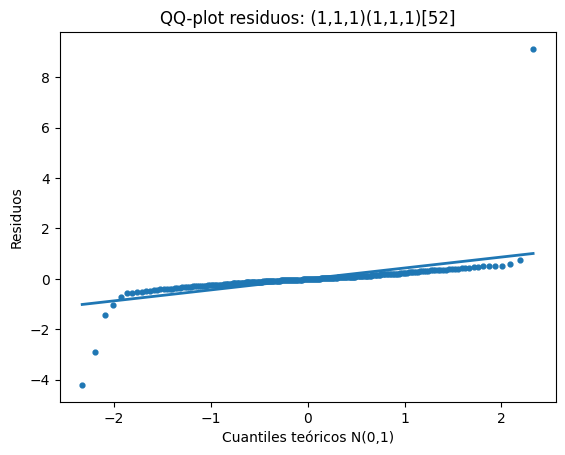

NameError: name 'res_aa' is not defined

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera

def diagnosticos_residuos(res, name="modelo"):
    resid = res.resid.dropna()

    print(f"\n=== Diagnósticos {name} ===")
    # Ljung-Box (usar lags representativos: 12, 24, 52)
    print("Ljung-Box:")
    print(acorr_ljungbox(resid, lags=[12,24,52], return_df=True))

    # ARCH LM (heterocedasticidad condicional)
    # het_arch devuelve (LM stat, LM pval, F stat, F pval)
    lm_stat, lm_pval, f_stat, f_pval = het_arch(resid, nlags=12)
    print(f"ARCH LM (lags=12): LM pval={lm_pval:.4f}  F pval={f_pval:.4f}")

    # Normalidad (Jarque-Bera)
    jb_stat, jb_pval, _, _ = jarque_bera(resid)
    print(f"Jarque-Bera: pval={jb_pval:.4f}")

    # QQ-plot
    import scipy.stats as st
    sm = np.sort(resid.values)
    theo_q = st.norm.ppf(np.linspace(0.01,0.99,len(sm)))
    plt.scatter(theo_q, sm, s=12)
    a, b = np.polyfit(theo_q, sm, 1)
    plt.plot(theo_q, a*theo_q + b, lw=2)
    plt.title(f"QQ-plot residuos: {name}")
    plt.xlabel("Cuantiles teóricos N(0,1)")
    plt.ylabel("Residuos")
    plt.show()

# Diagnóstico del candidato 1 y del AA
cand1_key = ((1,1,1),(1,1,1,52))
if cand1_key in resultados:
    diagnosticos_residuos(resultados[cand1_key], name="(1,1,1)(1,1,1)[52]")

diagnosticos_residuos(res_aa, name="AA (3,1,1)(1,0,1)[52] con drift")

## 9) Pronóstico h=52 semanas y des-log (expm1)

In [25]:
h = 52

# Forecast candidato 1 (si existe)
if cand1_key in resultados:
    fc1_bc = resultados[cand1_key].get_forecast(steps=h)
    fc1_mean = np.expm1(fc1_bc.predicted_mean)    # invertimos log1p
    fc1_ci   = np.expm1(fc1_bc.conf_int())        # invertimos intervalos
    fc1 = pd.DataFrame({'mean': fc1_mean, 'lo': fc1_ci.iloc[:,0], 'hi': fc1_ci.iloc[:,1]})
else:
    fc1 = None

# Forecast auto.arima AA
fcaa_bc = res_aa.get_forecast(steps=h)
fcaa_mean = np.expm1(fcaa_bc.predicted_mean)
fcaa_ci   = np.expm1(fcaa_bc.conf_int())
fcaa = pd.DataFrame({'mean': fcaa_mean, 'lo': fcaa_ci.iloc[:,0], 'hi': fcaa_ci.iloc[:,1]})

# Plots
plt.figure(figsize=(9,4))
plt.plot(y, label='Real')
if fc1 is not None:
    plt.plot(fc1['mean'], label='fc (1,1,1)(1,1,1)')
plt.plot(fcaa['mean'], label='fc AA (3,1,1)(1,0,1)')
plt.legend(); plt.title("Pronósticos 52 semanas"); plt.show()

# Guardar CSV 
if fc1 is not None: fc1.to_csv("Forecast_fitventacodun_1.csv")
fcaa.to_csv("Forecast_fitventacodun_aa.csv")


c:\Users\elipa\AppData\Local\pypoetry\Cache\virtualenvs\ast1-ceia-uba-tp3-7xOI4lxw-py3.11\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: overflow encountered in expm1
  result = func(self.values, **kwargs)


NameError: name 'res_aa' is not defined

## 10) Evaluación con serie holdout (2020-28 → 2021-27)

In [ ]:
# Cargar observados reales del período de evaluación
test = pd.read_excel("data/Pedidos_real.xlsx")

# Si vienen año/semana:
if {'año','semana'}.issubset(test.columns):
    test['fecha'] = pd.to_datetime(test['año'].astype(str)+test['semana'].astype(str)+'1',
                                   format='%G%V%u')
    test = test.rename(columns={'pedido':'Observado'}).sort_values('fecha').set_index('fecha')
else:
    # Si ya viene 'fecha' y 'pedido', solo renombrar y setear index:
    test = test.rename(columns={'pedido':'Observado'})
    test['fecha'] = pd.to_datetime(test['fecha'])
    test = test.sort_values('fecha').set_index('fecha')

y_obs = test['Observado'].asfreq('W-MON')

def eval_forecast(y_true, y_pred):
    # Errores relativos y métricas tipo R
    pe = (y_true - y_pred) / y_true.replace(0, np.nan)
    mape = np.mean(np.abs(pe.dropna())) * 100
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    acc25 = (np.abs(pe) < 0.25).sum() / len(y_true)   # % con error < 25%
    return pe, {'MAPE%': mape, 'RMSE': rmse, 'Acc(<25%)': acc25}

# Alinear índices (y_pred está futuro; recortar a índices del test)
def align_pred(fc_df, y_true):
    # fc_df tiene 'mean' y un index de fechas futuro
    common_idx = y_true.index.intersection(fc_df.index)
    return fc_df.loc[common_idx, 'mean'], y_true.loc[common_idx]

results = {}
if fc1 is not None:
    fc1_al, y1_al = align_pred(fc1, y_obs)
    pe1, met1 = eval_forecast(y1_al, fc1_al)
    results['(1,1,1)(1,1,1)'] = met1

fcaa_al, yaa_al = align_pred(fcaa, y_obs)
peaa, metaa = eval_forecast(yaa_al, fcaa_al)
results['AA (3,1,1)(1,0,1)'] = metaa

pd.DataFrame(results).T
